# Lineare Regression mit 1 Feature ($d=1$)

In [1]:
import numpy as np
import pandas as pd
# plotting settings
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Wir verwenden hier beispielhaft den Datensatz [Melbourne Housing Snapshot](https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot). Diesen finden Sie auch im Moodle unter `data/kaggle/melb_data.csv`.

In [2]:
melbourne_file_path = 'data/melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path)
melbourne_data = melbourne_data.dropna(axis=0)  # entfernen von Daten mit fehlenden Werten
melbourne_data.columns  # Spaltennamen der Tabelle (potentielle Features)

Index(['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG',
       'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude',
       'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')

In [3]:
melbourne_data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0
6,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,...,2.0,0.0,245.0,210.0,1910.0,Yarra,-37.8024,144.9993,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,...,1.0,2.0,256.0,107.0,1890.0,Yarra,-37.8060,144.9954,Northern Metropolitan,4019.0


<AxesSubplot: xlabel='BuildingArea', ylabel='Price'>

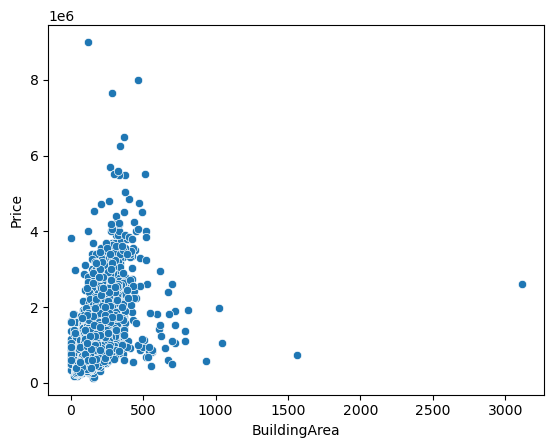

In [4]:
sns.scatterplot(x=melbourne_data['BuildingArea'], y=melbourne_data['Price'])

In [5]:
# wählen für unser Beispiel einen kleinen Ausschnitt aus den Daten
max_area = 400
max_datapoints = 100
data = melbourne_data[melbourne_data['BuildingArea'] < max_area][:max_datapoints][['BuildingArea', 'Price']]
data.head()

,BuildingArea,Price
1,79.0,1035000.0
2,150.0,1465000.0
4,142.0,1600000.0
6,210.0,1876000.0
7,107.0,1636000.0


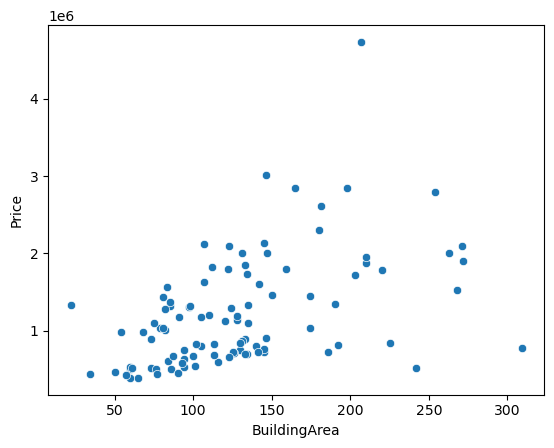

In [6]:
ax = sns.scatterplot(x=data['BuildingArea'], y=data['Price'])

In [7]:
X = []
Y = []
for _, row in data.iterrows():
    X.append([1] + [row['BuildingArea']])
    Y.append(row['Price'])
X = np.array(X)
Y = np.array(Y)
print(X[:5], Y[:5])

[[  1.  79.]
 [  1. 150.]
 [  1. 142.]
 [  1. 210.]
 [  1. 107.]] [1035000. 1465000. 1600000. 1876000. 1636000.]


In [8]:
def h_w(x, w):
    return w[0] + w[1]*x

## Analytische Lösung der linearen Regression

`np.linalg.solve(A, b)` berechnet $w$ im linearen Gleichungssystem

$ A w = b $

$A$ - Matrix,
$w$ - Vektor (unsere unbekannten),
$b$ - Vektor.

Wir suchen die Lösung $w$ im folgenden Gleichungssystem:

$$ X^T X w = X^T Y $$

Mit $A = X^TX$ und $b = X^T Y$ berechnet `np.linalg.solve(A, b)` unsere gesuchten Paramter für die lineare Regression.

In [9]:
%%time
w_ana = np.linalg.solve(X.T @ X, X.T @ Y)

CPU times: user 47 µs, sys: 6 µs, total: 53 µs
Wall time: 54.8 µs


In [10]:
print(w_ana)

[441524.42083181   6024.22929588]


Plot der analytischen Lösung

<AxesSubplot: xlabel='BuildingArea', ylabel='Price'>

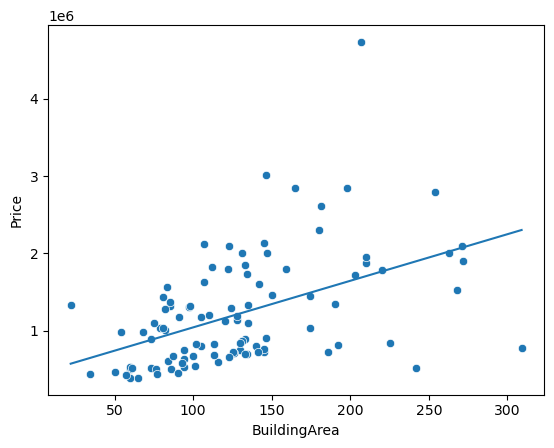

In [11]:
ax = sns.scatterplot(x=data['BuildingArea'], y=data['Price'])

xplot = [min(data['BuildingArea']), max(data['BuildingArea'])]
yplot = [h_w(x, w_ana) for x in xplot]
sns.lineplot(x=xplot, y=yplot, ax=ax)

In [12]:
# Definition der Kostenfunktion
def J(w, x, y):
    """w, x, y müssen numpy arrays sein"""
    errors = y - h_w(x=x, w=w)
    mse = 1.0/(2.0*len(errors)) * ( errors @ errors )
    return mse

In [13]:
x = data['BuildingArea'].to_numpy(copy=True)
y = data['Price'].to_numpy(copy=True)
J_ana = J(w=w_ana, x=x, y=y)
print('Kosten der analytischen Lösung: {}'.format(J_ana))

Kosten der analytischen Lösung: 200141433273.1325


## Numerische Lösung mit Gradient Descent

In [14]:
def grad_desc_upd(w, alpha, x, y):
    """y, x sind Vektoren (numpy-arrays)"""
    errors = y - h_w(x=x, w=w)
    w_0_upd = w[0] + alpha * sum(errors)
    errors_x_x1 = errors @ x
    w_1_upd = w[1] + alpha * errors_x_x1
    return [w_0_upd, w_1_upd]

In [15]:
def grad_desc(w, alpha, x, y, n_iterations):
    J_all = [J(w=w, x=x, y=y)]
    for it in range(n_iterations):
        w = grad_desc_upd(w=w, alpha=alpha, x=x, y=y)
        J_all.append(J(w=w, x=x, y=y))
    return w, J_all

In [16]:
%%time
n_iterations = 100000
alpha = 0.0000005  # mit alpha experimentieren
w_init = [1e6, 1000.]
x = data['BuildingArea'].to_numpy()
y = data['Price'].to_numpy()
w_gd_1e5, J_all_1e5 = grad_desc(w=w_init, alpha=alpha, x=x, y=y, n_iterations=n_iterations)

print('w_gd_1e5: {}'.format(w_gd_1e5))
print('Vergleich zu Startkosten: {}'.format(J_all_1e5[-1]/J_all_1e5[0]))
print('Vergleich zu analytischer Lösung: {}'.format(J_all_1e5[-1]/J_ana))
print('(w0_gd - w0_ana)/w0_ana: {}'.format((w_gd_1e5[0]-w_ana[0])/w_ana[0]))
print('(w1_gd - w1_ana)/w0_ana: {}'.format((w_gd_1e5[1]-w_ana[1])/w_ana[1]))

w_gd_1e5: [686235.5653584576, 4440.301435742261]
Vergleich zu Startkosten: 0.8347751073398797
Vergleich zu analytischer Lösung: 1.0246898880149078
(w0_gd - w0_ana)/w0_ana: 0.5542414710960255
(w1_gd - w1_ana)/w0_ana: -0.2629262238107525
CPU times: user 1.1 s, sys: 4.7 ms, total: 1.11 s
Wall time: 856 ms


In [17]:
%%time
n_iterations = 300000
alpha = 0.0000005  # mit alpha experimentieren
w_init = [1e6, 1000.]
x = data['BuildingArea'].to_numpy()
y = data['Price'].to_numpy()
w_gd_3e5, J_all_3e5 = grad_desc(w=w_init, alpha=alpha, x=x, y=y, n_iterations=n_iterations)

print('w_gd_3e5: {}'.format(w_gd_3e5))
print('Vergleich zu Startkosten: {}'.format(J_all_3e5[-1]/J_all_3e5[0]))
print('Vergleich zu analytischer Lösung: {}'.format(J_all_3e5[-1]/J_ana))
print('(w0_gd - w0_ana)/w0_ana: {}'.format((w_gd_3e5[0]-w_ana[0])/w_ana[0]))
print('(w1_gd - w1_ana)/w0_ana: {}'.format((w_gd_3e5[1]-w_ana[1])/w_ana[1]))

w_gd_3e5: [488507.197812836, 5720.126556499906]
Vergleich zu Startkosten: 0.8154026361718902
Vergleich zu analytischer Lösung: 1.0009100997376121
(w0_gd - w0_ana)/w0_ana: 0.10641036999156128
(w1_gd - w1_ana)/w0_ana: -0.05047994099189097
CPU times: user 2.53 s, sys: 7.81 ms, total: 2.53 s
Wall time: 2.54 s


In [18]:
%%time
n_iterations = 1000000
alpha = 0.0000005  # mit alpha experimentieren
w_init = [1e6, 1000.]
x = data['BuildingArea'].to_numpy()
y = data['Price'].to_numpy()
w_gd_1e6, J_all_1e6 = grad_desc(w=w_init, alpha=alpha, x=x, y=y, n_iterations=n_iterations)

print('w_gd_1e6: {}'.format(w_gd_1e6))
print('Vergleich zu Startkosten: {}'.format(J_all_1e6[-1]/J_all_1e6[0]))
print('Vergleich zu analytischer Lösung: {}'.format(J_all_1e6[-1]/J_ana))
print('(w0_gd - w0_ana)/w0_ana: {}'.format((w_gd_1e6[0]-w_ana[0])/w_ana[0]))
print('(w1_gd - w1_ana)/w0_ana: {}'.format((w_gd_1e6[1]-w_ana[1])/w_ana[1]))

w_gd_1e6: [441670.1129151497, 6023.286283043882]
Vergleich zu Startkosten: 0.8146612203450248
Vergleich zu analytischer Lösung: 1.000000008751521
(w0_gd - w0_ana)/w0_ana: 0.0003299751417198726
(w1_gd - w1_ana)/w0_ana: -0.00015653667668035203
CPU times: user 8.59 s, sys: 33 ms, total: 8.62 s
Wall time: 8.67 s


<AxesSubplot: >

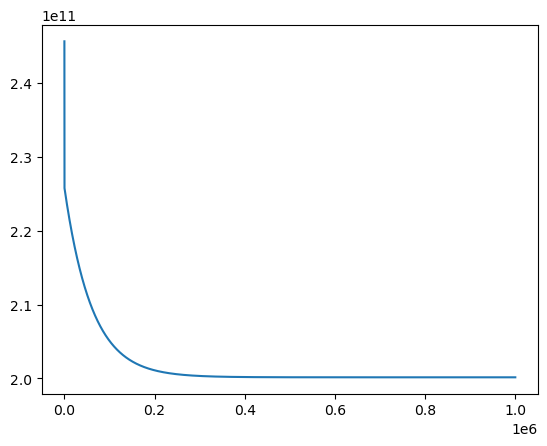

In [19]:
sns.lineplot(x=list(range(len(J_all_1e6))), y=J_all_1e6)

### Plotten der Ergebnisse und Vergleich zwischen analytischer und numerischer Lösung
Nach $10^5$ Schritten des Gradient Descent Algoreithmus weicht der lineare fit noch etwas von der analytischen Lösung ab. Nach $3 \times 10^5$ Schritten ist der Unterschied im Plot kaum noch zu erkennen.
Die numerische Lösung war in diesem Beispiel deutlich langsamer als die analytische.

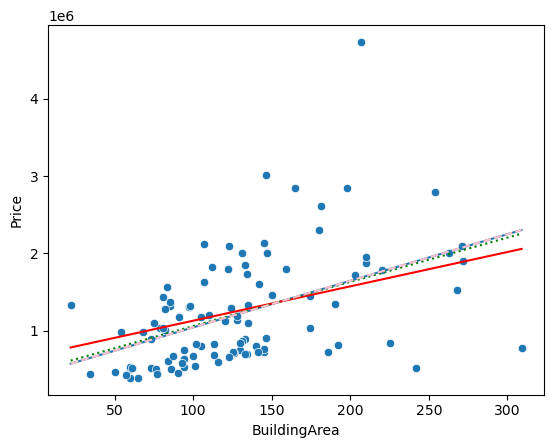

In [20]:
# plot
xplot = [min(data['BuildingArea']), max(data['BuildingArea'])]
yplot_ana = [h_w(x, w_ana) for x in xplot]
yplot_gd = [h_w(x, w_gd_1e5) for x in xplot]
yplot_gd_3e5 = [h_w(x, w_gd_3e5) for x in xplot]
yplot_gd_1e6 = [h_w(x, w_gd_1e6) for x in xplot]
ax = sns.scatterplot(x=data['BuildingArea'], y=data['Price'])
ax = sns.lineplot(x=xplot, y=yplot_ana, ax=ax)
ax = sns.lineplot(x=xplot, y=yplot_gd, color='red', ax=ax)
ax = sns.lineplot(x=xplot, y=yplot_gd_3e5, color='green', linestyle='dotted', ax=ax)
ax = sns.lineplot(x=xplot, y=yplot_gd_1e6, color='pink', linestyle='--', ax=ax)

## Vorhersagen unseres Modells

Man kann die Vorhersagen des Modells entweder im Plot oben auf der Geraden ablesen. Zu jedem Wert von `BuildingArea` (x-Achse des Plots) kann so der `Preis` auf der y-Achse abgelesen werden.

Alternativ können wir die von uns oben definierte Funktion `h_w(x, w)` aufrufen. Der Parameter `w` ist die gefunden Lösung und `x` die `BuildingArea` für die wir einen Preis vorhersagen wollen.

In [21]:
# Beispiel: Vorhersage unseres Modells für ein Haus mit Wohnfläche 287:
# wir machen je eine Vorhersage mit
# 1. den analytisch gefundenen Paramtern
# 2. den mit Gradient Descent nach 10^5 Iterationen gefundenen Parametern
# 3. den mit Gradient Descent nach 3*10^5 Iterationen gefundenen Parametern
building_area_new = 287
price_ana = h_w(x=building_area_new, w=w_ana)
price_1e5 = h_w(x=building_area_new, w=w_gd_1e5)
price_3e5 = h_w(x=building_area_new, w=w_gd_3e5)
price_1e6 = h_w(x=building_area_new, w=w_gd_1e6)
print('Preis laut analytischem Modell: {:.2f}'.format(price_ana))
print('Preis laut Gradient Descent Modell nach 10^5 Iterationen: {:.2f}'.format(price_1e5))
print('Preis laut Gradient Descent Modell nach 3*10^5 Iterationen: {:.2f}'.format(price_3e5))
print('Preis laut Gradient Descent Modell nach 1*10^6 Iterationen: {:.2f}'.format(price_1e6))

Preis laut analytischem Modell: 2170478.23
Preis laut Gradient Descent Modell nach 10^5 Iterationen: 1960602.08
Preis laut Gradient Descent Modell nach 3*10^5 Iterationen: 2130183.52
Preis laut Gradient Descent Modell nach 1*10^6 Iterationen: 2170353.28


## $R^2$

In [22]:
x = data['BuildingArea'].to_numpy(copy=True)
y = data['Price'].to_numpy(copy=True)
J_ana = J(w=w_ana, x=x, y=y)
MSE = 2*J_ana
mu_y = sum(y)/len(y)
sigma_y_quadrat = ( (y - mu_y) @ (y - mu_y) ) / len(y)
R2 = 1 - MSE/sigma_y_quadrat
print('erklärte Varianz / R^2: {}'.format(R2))

erklärte Varianz / R^2: 0.22971025499088604
